In [1]:
# 获取所有的数据
# 对标题,脚注,引用,标点和大小写进行数据清洗
from sklearn.datasets import fetch_20newsgroups
newsgroups_all = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

all_data = newsgroups_all.data
# 查看数据集和数据量
print("数据量:\n",len(all_data))
print("数据集:\n",all_data[1])

数据量:
 18846
数据集:
 My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt



In [2]:
# 去除符号，处理大小写问题
import re
def clear_data(data):
    res = re.sub('[\W]+', ' ', data.lower())
    return res.strip()
all_data=list(map(clear_data,all_data))
# 查看数据集和数据量
print("数据量:\n",len(all_data))
print("数据集:\n",all_data[1])

数据量:
 18846
数据集:
 my brother is in the market for a high performance video card that supports vesa local bus with 1 2mb ram does anyone have suggestions ideas on diamond stealth pro local bus orchid farenheit 1280 ati graphics ultra pro any other high performance vlb card please post or email thank you matt


标签名:
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Text(0.5,1,'All Data Distribution')

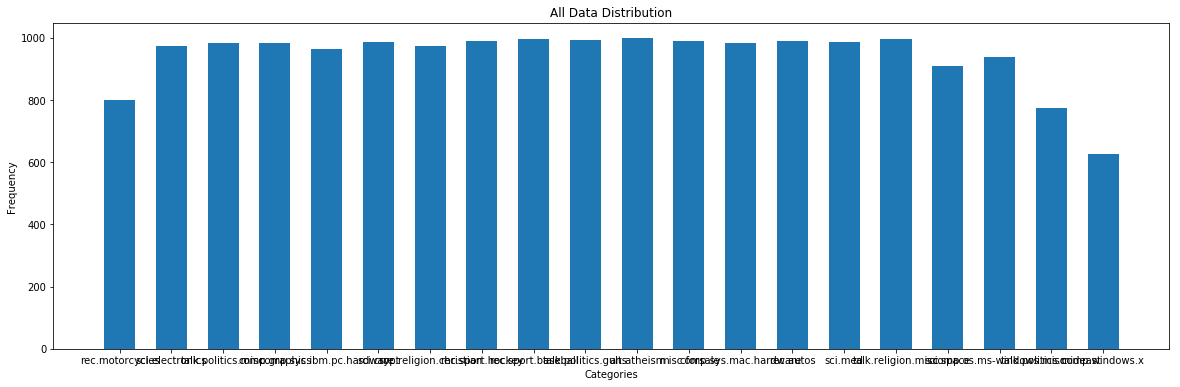

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
labels = newsgroups_all.target
label_names = newsgroups_all.target_names
# 查看标签名
print("标签名:\n",label_names)
# 查看数据的分布情况
label_des = Counter(labels)
plt.figure(figsize=(20,6))
plt.bar(list(label_des.keys()), list(label_des.values()), tick_label = label_names,width = 0.6)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('All Data Distribution')

In [4]:
# 统计词频和文章长度
total_word = Counter()
d_length = []
def count_doc(data):
    for d in data:
        # 处理后，获取这篇文档的所有单词数
        d_length.append(len(d.split()))
        for word in d.split():
            # 统计每个单词出现的次数
            total_word[word] += 1
    return d_length, total_word

d_length, total_word = count_doc(all_data)
print(total_word.most_common(10))

[('the', 173592), ('to', 86907), ('of', 77192), ('a', 73928), ('and', 70083), ('ax', 62396), ('i', 59683), ('in', 50898), ('is', 48899), ('that', 45942)]


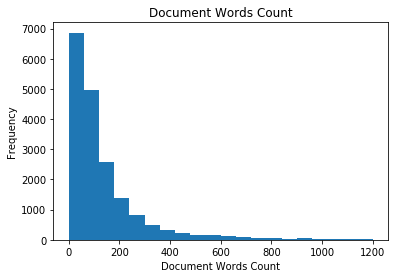

In [5]:
# 文档词数分布情况
plt.hist(d_length, range=(0,1200),bins=20)  
plt.xlabel('Document Words Count')
plt.ylabel('Frequency')
plt.title('Document Words Count')
plt.show()

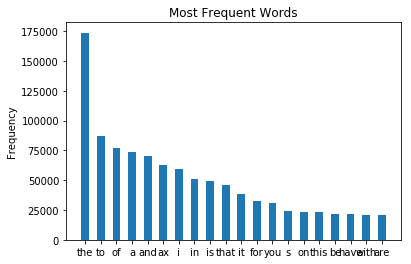

In [8]:
# 文档长度分布
x_val = [i[0] for i in total_word.most_common(20)]
y_val = [i[1] for i in total_word.most_common(20)]
plt.bar(x=range(20),height=y_val,width=0.5)
plt.xticks(range(20),x_val)
plt.title('Most Frequent Words')
plt.ylabel('Frequency')
plt.show()

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 保留词频小于等于20000个单词
MAX_NB_WORDS = 20000 
# 每篇文档限定1000词以内
MAX_SEQUENCE_LENGTH = 1000 

# 构建分词器
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# 将所有数据放到分词器里边
tokenizer.fit_on_texts(all_data)
# 文本转化为数字序列
sequences = tokenizer.texts_to_sequences(all_data)
# 构建词汇表
word_index = tokenizer.word_index 

# 按照最大文本长度截断文本
features = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# 查看数字序列和词汇表
# print("数字序列:\n",sequences[:2])
# print("词汇表:\n",len(word_index))

In [11]:
# 对标签进行独热编码
from keras.utils import to_categorical
labels = to_categorical(labels)
print("经独热编码之后的标签:",labels[:2])

经独热编码之后的标签: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
# 将数据拆分成训练集,验证集,测试集
from sklearn.model_selection import train_test_split
# 测试集占据0.2
x_tv, x_test, y_tv, y_test = train_test_split(features, labels, test_size=0.2) 
# 验证集占据训练集中的0.2
x_train, x_val, y_train, y_val = train_test_split(x_tv, y_tv, test_size=0.2) 
print("x的维度:\n",x_train.shape, x_val.shape, x_test.shape)
print("y的维度:\n",y_train.shape, y_val.shape, y_test.shape)

x的维度:
 (12060, 1000) (3016, 1000) (3770, 1000)
y的维度:
 (12060, 20) (3016, 20) (3770, 20)


In [13]:
# 从GloVe文件中解析出每个词和它所对应的词向量，并用字典的方式存储
import numpy as np
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as txtfile:
    lines = txtfile.readlines()
    for line in lines:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("embeddings_index len:\n",len(embeddings_index))
print("embeddings_index val:\n",embeddings_index['the'])

embeddings_index len:
 400000
embeddings_index val:
 [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.725

In [14]:
# 构建词向量矩阵, 没有的单词的词向量均为0
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# 统计零值
count_zero = 0
for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        count_zero += 1
        embedding_matrix[idx] = embed_vector
        
print("embedding_matrix val:\n",embedding_matrix)
prop = count_zero * 1.0 / embedding_matrix.shape[0]
print("零值比列：\n",1 - prop)

embedding_matrix val:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
零值比列：
 0.5365913650373946


In [15]:
# 词向量加载到embedding层中
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# 构建CNN模型

In [16]:
import keras
from keras.layers import Dense,Input
from keras.layers import Conv1D, MaxPooling1D, Concatenate, Flatten, Dropout
from keras.models import Model
tb = [keras.callbacks.TensorBoard(log_dir='./logs')]

In [17]:
# （Conv1D-MaxPooling1D）* 3 - Flatten - Dropout - Dense * 2
main_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float64')
# 使用已训练完成的词向量
embedding_layer = Embedding(len(word_index) + 1, embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embed = embedding_layer(main_input)
# 使用3层卷积池化
x = Conv1D(128, 5, activation='relu')(embed)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dropout(0.2)(x) # 丢弃20%
x = Dense(128, activation='relu')(x)
preds = Dense(20, activation='softmax')(x)
model = Model(inputs=main_input, outputs=preds)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary()) # 查看模型概况

# history_cnn记录训练结果
history_cnn = model.fit(x_train, y_train, batch_size=128, epochs=25, callbacks=tb, validation_data=(x_val, y_val))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         13009900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
___________________________________________________________

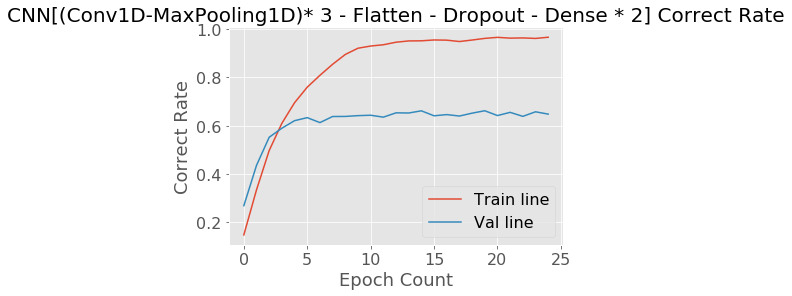

In [18]:
# 绘制模型的训练和验证曲线
plt.style.use('ggplot')

plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc']) 

plt.legend(['Train line', 'Val line'], loc='lower right', fontsize=16)

plt.title('CNN[(Conv1D-MaxPooling1D)* 3 - Flatten - Dropout - Dense * 2] Correct Rate', fontsize=20)
plt.xlabel('Epoch Count', fontsize=18)
plt.ylabel('Correct Rate', fontsize=18)

plt.xticks(range(0, 26, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [19]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

3770/3770 [==============================] - 13s 3ms/step
Test score: 2.7333349334150157
Test accuracy: 0.6419098142287459


In [21]:
# 模型结构：CNN-LSTM
from keras.models import Sequential
from keras.layers import LSTM,Activation
from keras import regularizers
from keras.layers.core import *
model = Sequential()
model.add(Embedding(len(word_index) + 1,embedding_dim, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(activation="relu", padding="same", filters=128, kernel_size=5))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(20, activation='softmax',kernel_regularizer=regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.001)))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history_rnn = model.fit(x_train, y_train, batch_size=128, epochs=60,
                        validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         13009900  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 128)         64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
Total params: 13,167,648
Trainable params: 13,167,648
Non-trainable params: 0
________________________________________________________________

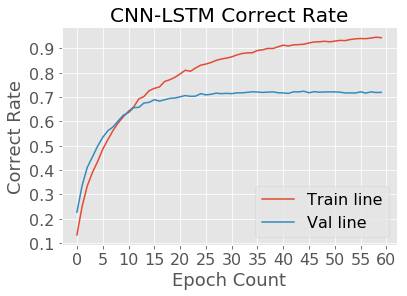

In [22]:
# 绘制训练和验证曲线
plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])

plt.legend(['Train line', 'Val line'], loc='lower right', fontsize=16)

plt.title('CNN-LSTM Correct Rate', fontsize=20)
plt.xlabel('Epoch Count', fontsize=18)
plt.ylabel('Correct Rate', fontsize=18)

plt.xticks(range(0, 61, 5), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [23]:
# 模型测试 评估
score, acc = model.evaluate(x_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

3770/3770 [==============================] - 15s 4ms/step
Test score: 1.353182756552962
Test accuracy: 0.7143236073005736
